In [ ]:
!pip install wfdb ipympl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.2 MB/s eta 0:00:00


In [ ]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss
import scipy.linalg as sl
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from tabulate import tabulate

In [ ]:
# %matplotlib widget

In [ ]:
from google.colab import output
# output.enable_custom_widget_manager()

Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
from google.colab import output
# output.disable_custom_widget_manager()

# Análisis de dataset

In [ ]:
signals, fields = wfdb.rdsamp('slp41')
signals = signals.T
fields

{'fs': 250,
 'sig_len': 5850000,
 'n_sig': 7,
 'base_date': datetime.date(1989, 8, 24),
 'base_time': datetime.time(23, 51, 30),
 'units': ['mV', 'mmHg', 'mV', 'l', 'l', 'mV', 'mV'],
 'sig_name': ['ECG',
  'BP',
  'EEG (C4-A1)',
  'Resp (nasal)',
  'Resp (abdominal)',
  'EOG (right)',
  'EMG'],
 'comments': ['45 M 145 48-08-89']}

In [ ]:
fs = 250
a = 3600*fs #3660*fs
b = 90*fs   #90*fs

delayECG = 10
delayEOG = 400

ECG = signals[0][a+delayECG:a+b+delayECG]*1e3
EEG = signals[2][a:a+b]*1e3
EOG = signals[5][a+delayEOG:a+b+delayEOG]*1e3

time = np.linspace(0, len(EEG)/fs, len(EEG))

In [ ]:
data = pd.DataFrame({'EEG': EEG, 'ECG': ECG, 'EOG': EOG})
media = data.mean()
varianza = data.var()
resultados = pd.DataFrame({'Media': media, 'Varianza': varianza})
print(resultados)

         Media      Varianza
EEG  -6.382844     52.472913
ECG -51.683022  13633.971791
EOG   4.944258    518.197179


In [ ]:
EEG = (EEG - np.mean(EEG))
ECG = (ECG - np.mean(ECG))
EOG = (EOG - np.mean(EOG))

<ipython-input-10-4df9832923c7>:16: RuntimeWarning: divide by zero encountered in log10
  pc= axes[i, 1].pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud',  vmin=-25, vmax=0)


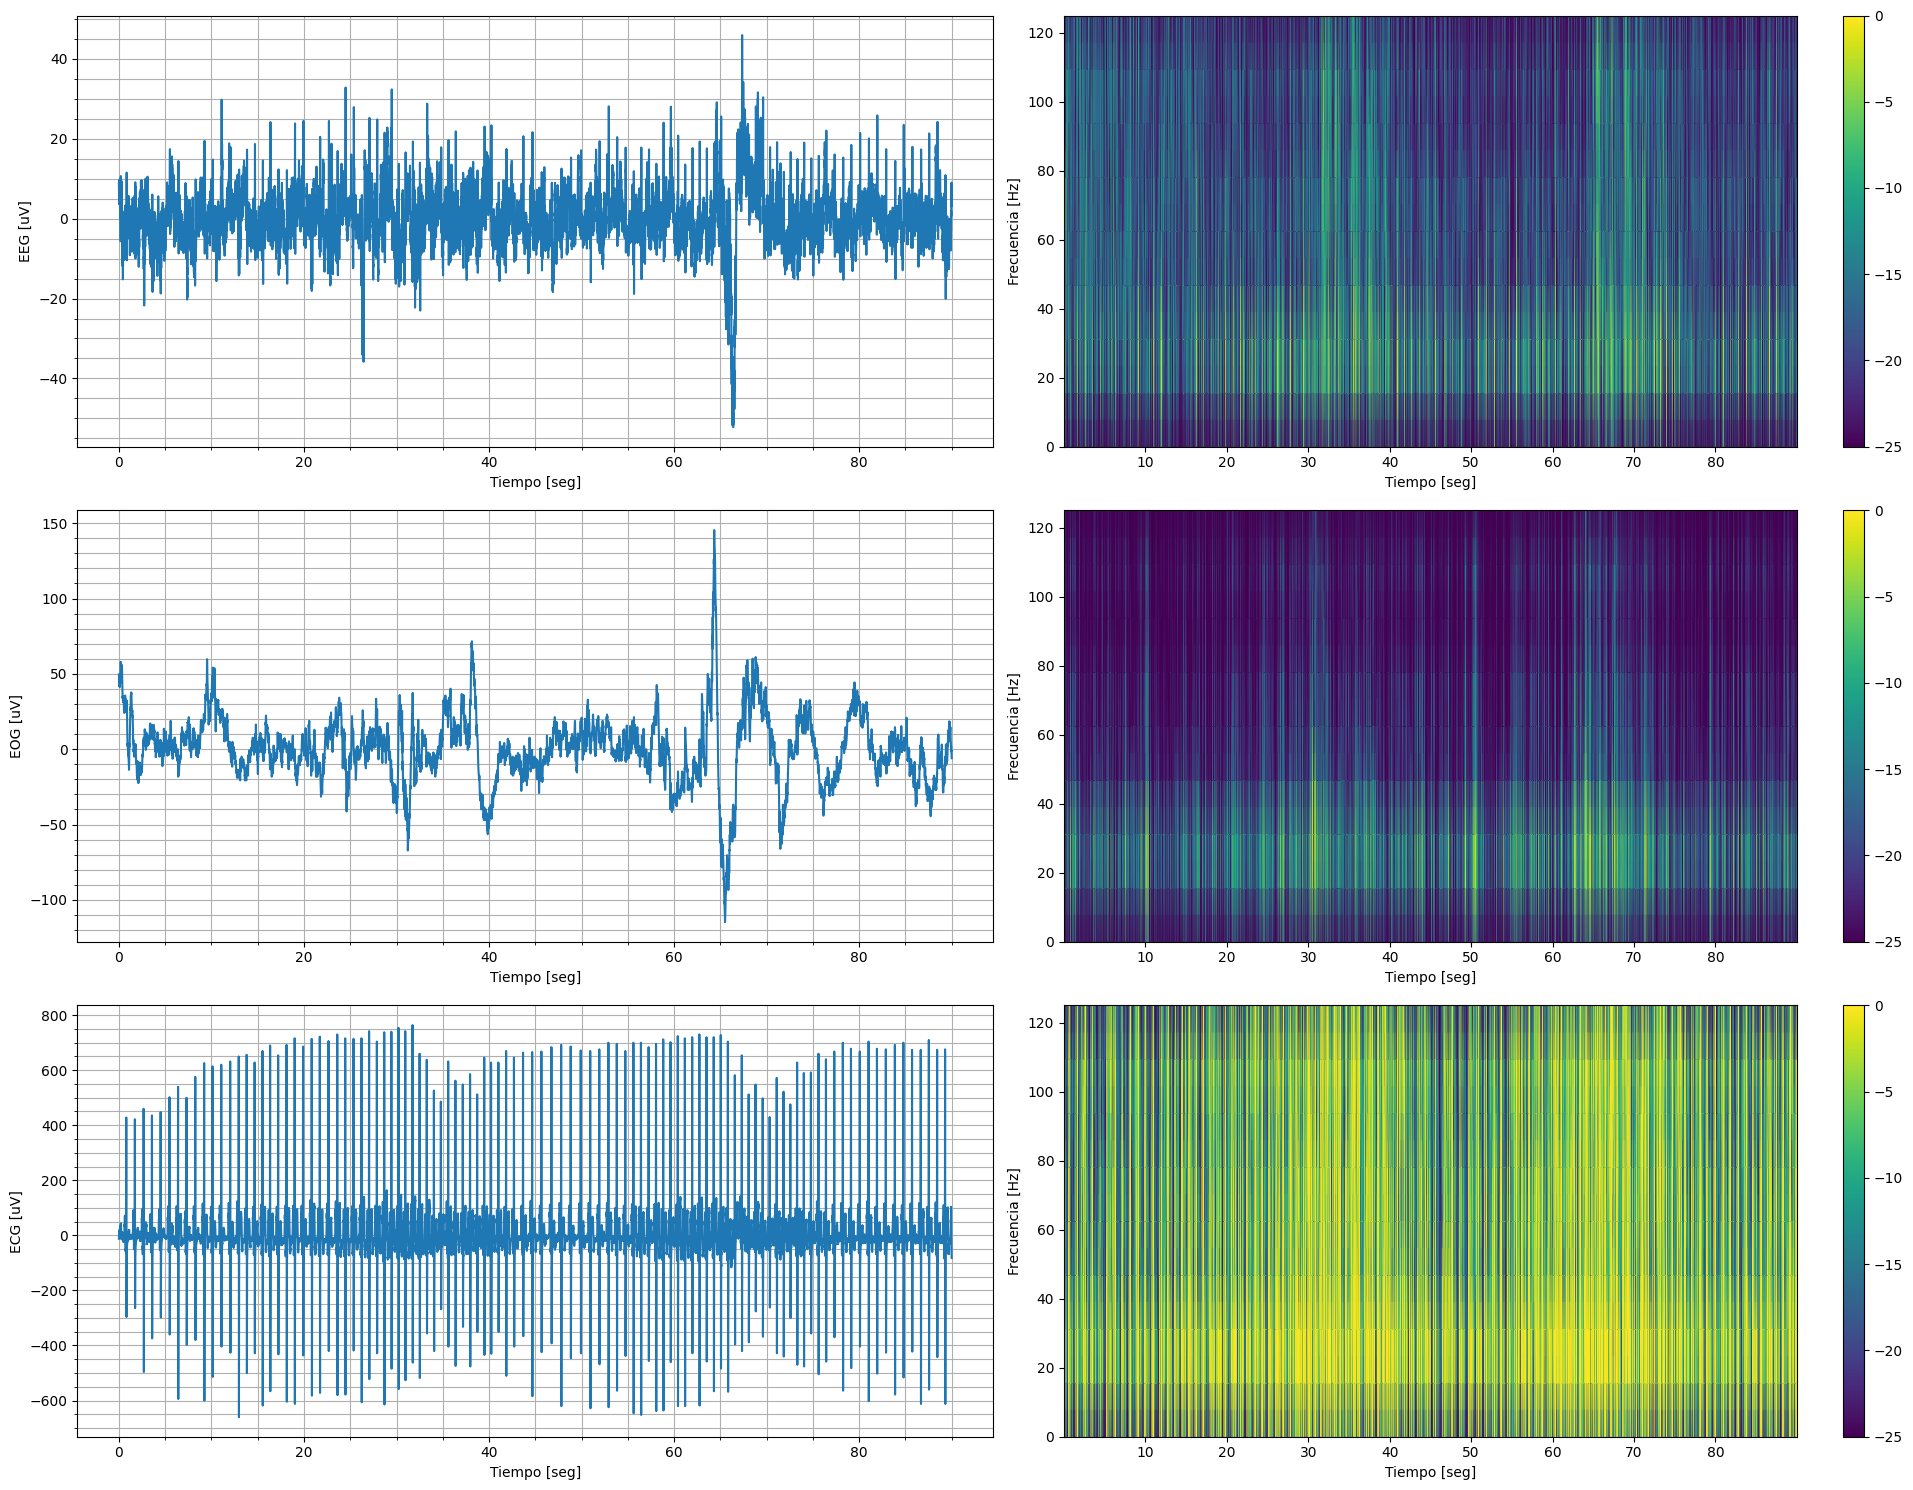

In [ ]:
data = [EEG, EOG, ECG]
labels = ['EEG', 'EOG', 'ECG']

fig, axes = plt.subplots(len(data), 2, figsize=(20, 15))
for i, (signal, label) in enumerate(zip(data, labels)):
    # Signal
    axes[i, 0].plot(time, signal)
    axes[i, 0].minorticks_on()
    axes[i, 0].grid(which='both')
    axes[i, 0].set_ylabel(label+' [uV]')
    axes[i, 0].set_xlabel('Tiempo [seg]')

    #Spectrogram
    nperseg = 8
    f, t, Sxx = ss.spectrogram(signal, fs, nperseg=nperseg, nfft=2*nperseg)
    pc= axes[i, 1].pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud',  vmin=-25, vmax=0)
    axes[i, 1].set_ylabel('Frecuencia [Hz]')
    axes[i, 1].set_xlabel('Tiempo [seg]')
    fig.colorbar(pc)

plt.tight_layout()
plt.show()

## Test estacionaridad

In [ ]:
#El valor de lags fue elegido por un tema computacional de RAM disponible
adf_eeg = adfuller(EEG, regression='n', autolag='t-stat', maxlag=100)

results = [
    ["EEG", adf_eeg[0], adf_eeg[1]],
]

headers = [" ", "Test Statistic", "P-value"]

table = tabulate(results, headers=headers, floatfmt=(".3f", ".3f", ".3f"), tablefmt="grid")

print(table)

+-----+------------------+-----------+
|     |   Test Statistic |   P-value |
+=====+==================+===========+
| EEG |           -9.966 |     0.000 |
+-----+------------------+-----------+


Como el valor p es bajo (menor al umbral de significancia 0.05), tenemos suficiente evidencia para rechazar la hipótesis nula, por lo que se puede decir que se valida la estacionaridad de las señales.

## Correlación

In [ ]:
def get_corr (signal1, signal2, auto=False):
    r = ss.correlate(signal1, signal2, mode='full')/len(signal1)
    if auto:
        r = r[len(r)//2:]
    return r

def plot_corr (r_ECG, r_EOG):
    x = np.arange(-len(r_EOG)//2,len(r_EOG)//2)

    # plt.figure(figsize=(12, 10))
    fig, ax = plt.subplots(2, 2, figsize=(12, 10))
    i = 0
    # ax[i].subplot(2, 2, 1)
    ax[0,0].plot(x,np.abs(r_ECG))
    ax[0,0].minorticks_on()
    ax[0,0].grid(True, which='both')
    ax[0,0].set_title('Correlación de EEG con ECG')
    ax[0,0].set_xlabel('Lags [n]')
    ax[0,0].set_ylabel('correlación')
    i += 1
    # ax[i].subplot(2, 2, 2)
    ax[1,0].plot(x,np.abs(r_EOG))
    ax[1,0].minorticks_on()
    ax[1,0].grid(True, which='both')
    ax[1,0].set_title('Correlación de EEG con EOG')
    ax[1,0].set_xlabel('Lags [n]')
    ax[1,0].set_ylabel('correlación')
    i += 1
    # ax[i].subplot(2, 2, 3)
    ax[0,1].plot(x[len(r_EOG)//2-100:len(r_EOG)//2+100],np.abs(r_ECG[len(r_EOG)//2-100:len(r_EOG)//2+100]))
    ax[0,1].minorticks_on()
    ax[0,1].grid(True, which='both')
    ax[0,1].set_title('Correlación de EEG con ECG zoom')
    ax[0,1].set_xlabel('Lags [n]')
    ax[0,1].set_ylabel('correlación')
    i += 1
    # ax[i].subplot(2, 2, 4)
    ax[1,1].plot(x[len(r_EOG)//2-1000:len(r_EOG)//2+1000],np.abs(r_EOG[len(r_EOG)//2-1000:len(r_EOG)//2+1000]))
    ax[1,1].minorticks_on()
    ax[1,1].grid(True, which='both')
    ax[1,1].set_title('Correlación de EEG con EOG zoom')
    ax[1,1].set_xlabel('Lags [n]')
    ax[1,1].set_ylabel('correlación')

    fig.tight_layout()
    fig.show()

def get_ev (r, M):
    R = sl.toeplitz(r[:M])
    ev = sl.eig(R)
    return(ev[0])

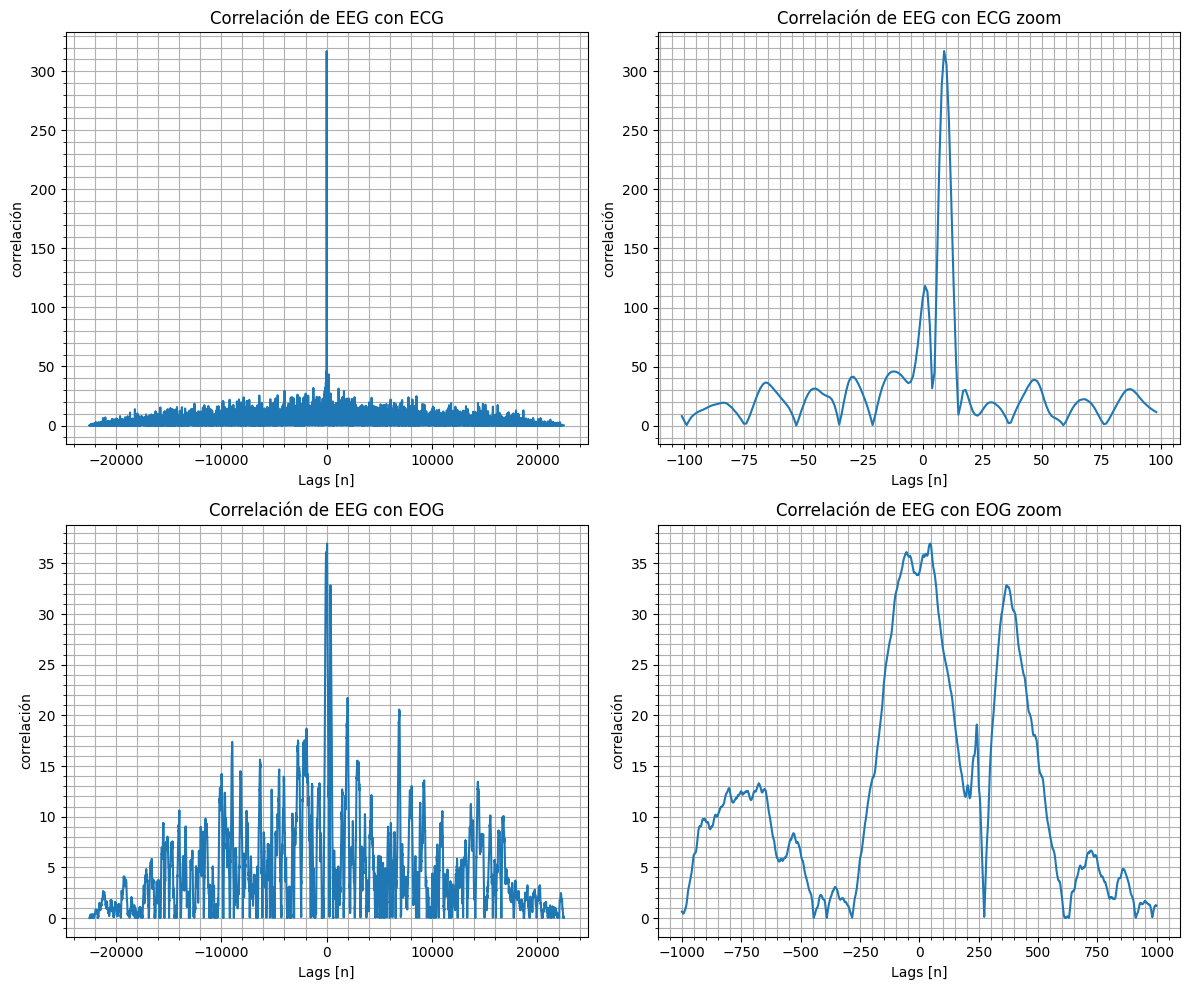

In [ ]:
r_ECG = get_corr(ECG, ECG, auto = True)
r_EOG = get_corr(EOG,EOG, auto = True)
r_EEG_ECG = get_corr(EEG,ECG)
r_EEG_EOG = get_corr(EEG,EOG)

plot_corr (r_EEG_ECG, r_EEG_EOG)

In [ ]:
M_ECG = 15
M_EOG = 750

ev_ECG = get_ev(r_ECG,M_ECG)
ev_EOG = get_ev(r_EOG,M_EOG)

ev_max_ECG = np.real(np.max(ev_ECG))
ev_max_EOG = np.real(np.max(ev_EOG))

u_max_ECG = 2/ev_max_ECG
u_max_EOG = 2/ev_max_EOG

spread_ECG = np.real(np.max(ev_ECG))/np.real(np.min(ev_ECG))
spread_EOG = np.real(np.max(ev_EOG))/np.real(np.min(ev_EOG))

print(f"λ_{{max ECG}} = {ev_max_ECG:.2e} \t χ= {spread_ECG:.2e}")
print(f"λ_{{max EOG}} = {ev_max_EOG:.2e} \t χ= {spread_EOG:.2e}")

print(f"0 < μ_ECG < {u_max_ECG:.2e}")
print(f"0 < μ_EOG < {u_max_EOG:.2e}")

λ_{max ECG} = 7.64e+04 	 χ= 2.94e+03
λ_{max EOG} = 1.24e+05 	 χ= 1.50e+06
0 < μ_ECG < 2.62e-05
0 < μ_EOG < 1.62e-05


# LMS

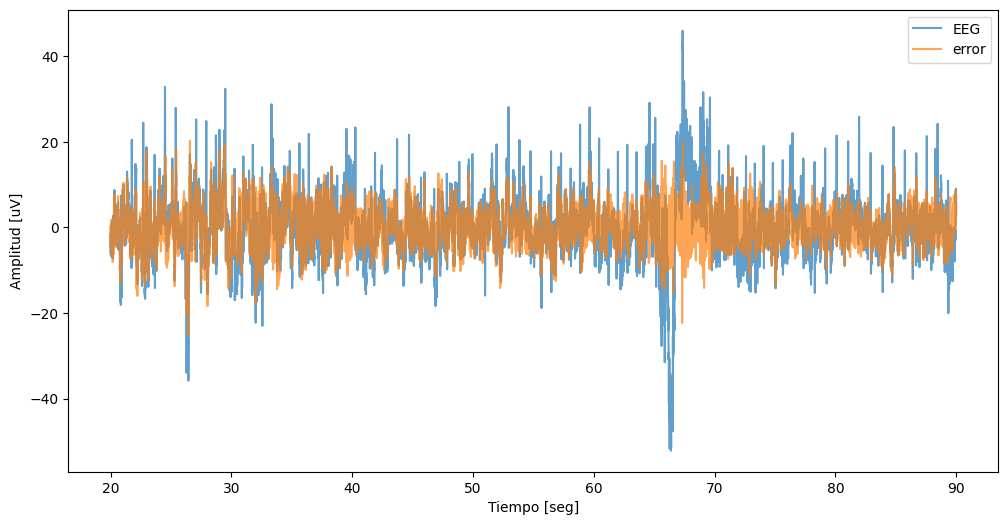

In [ ]:
def LMS (EEG, ECG, EOG, M_ECG = 15, M_EOG = 750, mu_ECG = 1e-7, mu_EOG = 1e-7):

    N = len(EEG)

    w_ECG = np.zeros(M_ECG)
    w_EOG = np.zeros(M_EOG)
    y_hat_ECG = np.zeros(N)
    y_hat_EOG = np.zeros(N)
    e_ECG = np.zeros(N)
    e_EOG = np.zeros(N)

    maxM = max(M_ECG, M_EOG)

    # Inicialización de primeros maxM valores en 0
    w_ECG_history = [[0]*M_ECG]*(maxM-1)
    w_EOG_history = [[0]*M_EOG]*(maxM-1)
    for n in range(maxM-1, N):
        ECG_n = ECG[n-M_ECG+1 : n+1]
        EOG_n = EOG[n-M_EOG+1 : n+1]

        y_hat_ECG[n] = np.dot(w_ECG, ECG_n)
        e_ECG[n] = EEG[n] - y_hat_ECG[n]

        y_hat_EOG[n] = np.dot(w_EOG, EOG_n)
        e_EOG[n] = e_ECG[n] - y_hat_EOG[n]

        w_ECG += mu_ECG * e_ECG[n] * ECG_n
        w_EOG += mu_EOG * e_EOG[n] * EOG_n

        w_ECG_history.append(w_ECG.copy())
        w_EOG_history.append(w_EOG.copy())

    return e_EOG, y_hat_ECG, y_hat_EOG, w_ECG_history, w_EOG_history

e, y_hat_ECG, y_hat_EOG, w_ECG, w_EOG = LMS(EEG, ECG, EOG)

t=np.arange(len(EEG))/fs
plt.figure(figsize=(12, 6))
plt.plot(t[20*fs:], EEG[20*fs:], alpha = 0.7, label = 'EEG')
plt.plot(t[20*fs:], e[20*fs:], alpha = 0.7, label = 'error')
plt.xlabel('Tiempo [seg]')
plt.ylabel('Amplitud [uV]')
plt.legend()
plt.show()

Se puede ver como se va adaptando, hasta lograr adaptarse al final

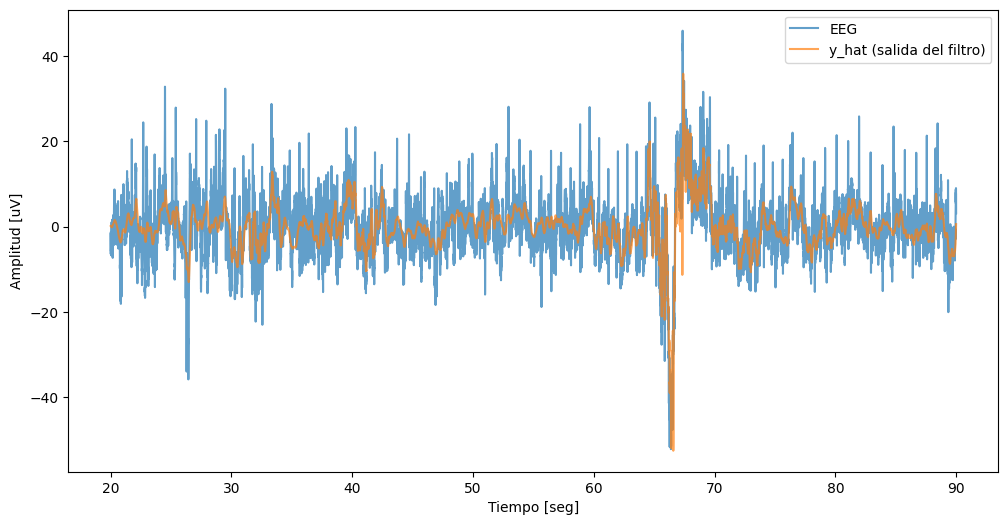

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(t[20*fs:], EEG[20*fs:], alpha = 0.7, label = 'EEG')
plt.plot(t[20*fs:], y_hat_EOG[20*fs:], alpha = 0.7, label = 'y_hat (salida del filtro)')
#plt.plot(t[20*fs:], y_hat_ECG[20*fs:], alpha = 0.7, label = 'y_hat (salida del filtro)')
plt.xlabel('Tiempo [seg]')
plt.ylabel('Amplitud [uV]')
plt.legend()
plt.show()

## Análisis de los coeficientes

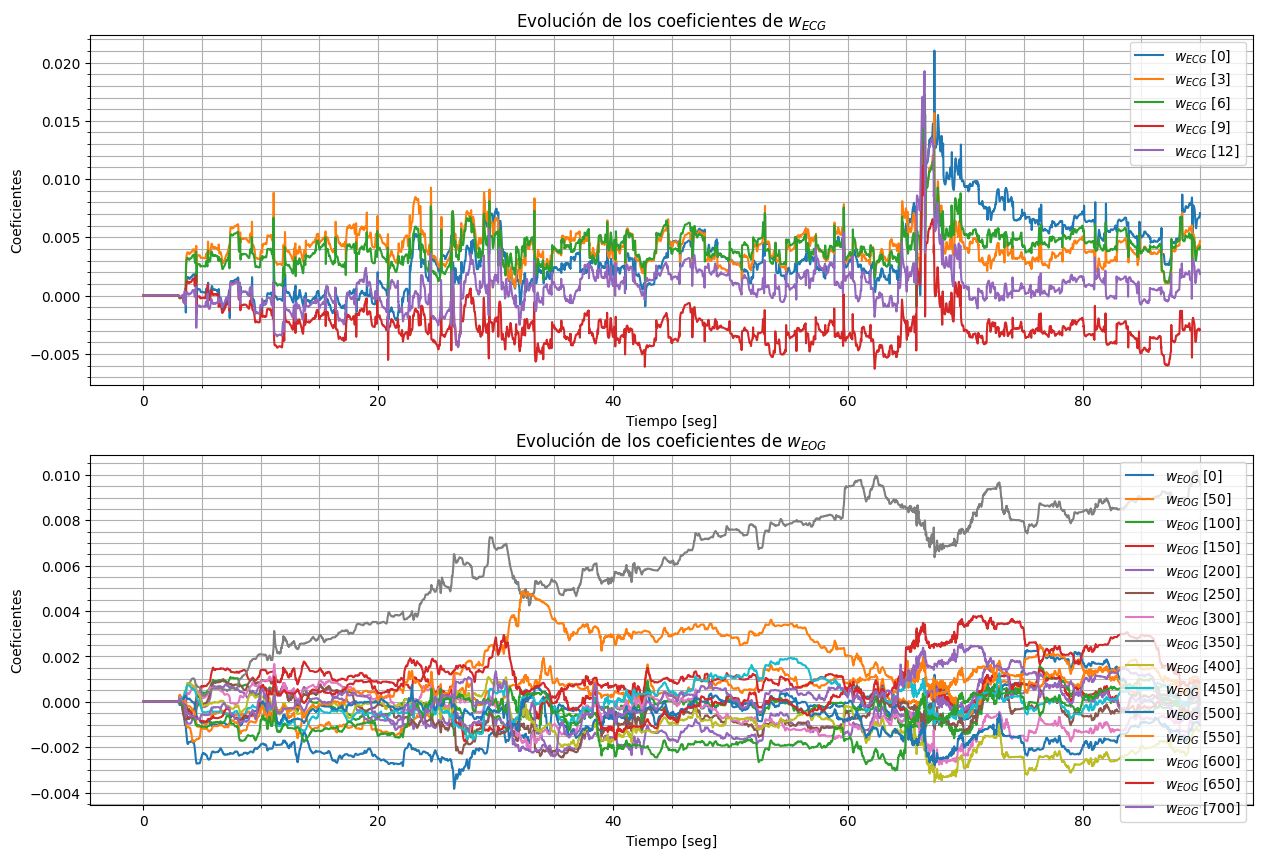

In [ ]:
def plot_coef_hist (EEG, w_ECG, w_EOG, fs=250):
    # plt.figure(figsize=(15, 10))
    fig, ax = plt.subplots(2, figsize=(15, 10), sharex=True)
    t=np.arange(len(EEG))/fs

    w_ECG_component = np.asarray(w_ECG)
    indexes_ECG = np.arange(0, w_ECG_component.shape[1], step=w_ECG_component.shape[1]//5)
    for i in indexes_ECG:
        w_ECG_component = [w[i] for w in w_ECG]
        ax[0].plot(t, w_ECG_component, label=f'$w_{{ECG}}$ [{i}]')

    ax[0].set_title('Evolución de los coeficientes de $w_{ECG}$')
    ax[0].set_xlabel('Tiempo [seg]')
    ax[0].set_ylabel('Coeficientes')
    ax[0].minorticks_on()
    ax[0].grid(True, which='both')
    ax[0].legend()
    ax[0].xaxis.set_tick_params(which='both', labelbottom=True)
    # plt.subplot(2, 1, 2)

    w_EOG_component = np.asarray(w_EOG)
    indexes_EOG = np.arange(0, w_EOG_component.shape[1], step=w_EOG_component.shape[1]//15)
    for i in indexes_EOG:
        ax[1].plot(t, w_EOG_component[:,i], label=f'$w_{{EOG}}$ [{i}]')

    ax[1].set_title('Evolución de los coeficientes de $w_{EOG}$')
    ax[1].set_xlabel('Tiempo [seg]')
    ax[1].set_ylabel('Coeficientes')
    ax[1].minorticks_on()
    ax[1].grid(True, which='both')
    ax[1].legend()

    plt.show()

plot_coef_hist(EEG, w_ECG, w_EOG)

## Cambio de los $\mu$

La métrica de comparación es la suma de la energía de la correlación cruzada entre las señales de ECG y EOG con EEG

In [ ]:
# Factor de mejora de las relaciones de energia
def get_factor(EEG, ECG, EOG, e):
  r_pre_ECG = get_corr(EEG, ECG, auto = False)
  r_pre_EOG = get_corr(EEG, EOG, auto = False)
  r_pos_ECG = get_corr(e, ECG, auto = False)
  r_pos_EOG = get_corr(e, EOG, auto = False)

  return np.sum(r_pre_ECG**2)/np.sum(r_pos_ECG**2), np.sum(r_pre_EOG**2)/np.sum(r_pos_EOG**2)

In [ ]:
mus_ECG = [1e-10, 8e-10, 2e-9, 2e-8]
mus_EOG = [1e-10, 8e-10, 2e-9, 2e-8]
# mus_EOG = [1e-6, 8e-6, 2e-5, 8e-5]

results = []

r_EEG_ECG = get_corr(EEG[12000:], ECG[12000:], auto = False)
r_EEG_EOG = get_corr(EEG[12000:], EOG[12000:], auto = False)
E_r_EEG_ECG = np.sum(r_EEG_ECG**2)
E_r_EEG_EOG = np.sum(r_EEG_EOG**2)

mu_ECG_matrix, mu_EOG_matrix = np.meshgrid(mus_ECG, mus_EOG)
fmECG_EOG_matrix = np.zeros_like(mu_ECG_matrix)

for mu_ECG in mus_ECG:
    for mu_EOG in mus_EOG:
        e, y_hat_ECG, y_hat_EOG, w_ECG, w_EOG = LMS(EEG, ECG, EOG, mu_ECG=mu_ECG, mu_EOG=mu_EOG)
        r_e_ECG = get_corr(e[12000:], ECG[12000:], auto = False)
        r_e_EOG = get_corr(e[12000:], EOG[12000:], auto = False)
        E_r_e_ECG = np.sum(r_e_ECG**2)
        E_r_e_EOG = np.sum(r_e_EOG**2)

        fmECG = E_r_EEG_ECG/E_r_e_ECG  # Factor de mejora ECG
        fmEOG = E_r_EEG_EOG/E_r_e_EOG  # Factor de mejora ECG

        results.append([f"{mu_ECG:.2e}", f"{mu_EOG:.2e}", f"{E_r_e_ECG:.2e}", f"{E_r_e_EOG:.2e}", f"{fmECG:.2e}", f"{fmEOG:.2e}"])

table = tabulate(results, headers=["mu_ECG", "mu_EOG", "Energía de r_error-ECG", "Energía de r_error-EOG", "Factor de mejora ECG", "Factor de mejora EOG"], tablefmt="fancy_grid")
print(table)

╒══════════╤══════════╤══════════════════════════╤══════════════════════════╤════════════════════════╤════════════════════════╕
│   mu_ECG │   mu_EOG │   Energía de r_error-ECG │   Energía de r_error-EOG │   Factor de mejora ECG │   Factor de mejora EOG │
╞══════════╪══════════╪══════════════════════════╪══════════════════════════╪════════════════════════╪════════════════════════╡
│    1e-10 │    1e-10 │                 2.3e+06  │                 4.44e+06 │                   1.13 │                   1.18 │
├──────────┼──────────┼──────────────────────────┼──────────────────────────┼────────────────────────┼────────────────────────┤
│    1e-10 │    8e-10 │                 2.24e+06 │                 2.86e+06 │                   1.16 │                   1.84 │
├──────────┼──────────┼──────────────────────────┼──────────────────────────┼────────────────────────┼────────────────────────┤
│    1e-10 │    2e-09 │                 2.17e+06 │                 2.23e+06 │                   1.2  │  

<ipython-input-33-224e9b6f3266>:17: RuntimeWarning: overflow encountered in square
  E_r_e_ECG = np.sum(r_e_ECG**2)
<ipython-input-33-224e9b6f3266>:18: RuntimeWarning: overflow encountered in square
  E_r_e_EOG = np.sum(r_e_EOG**2)


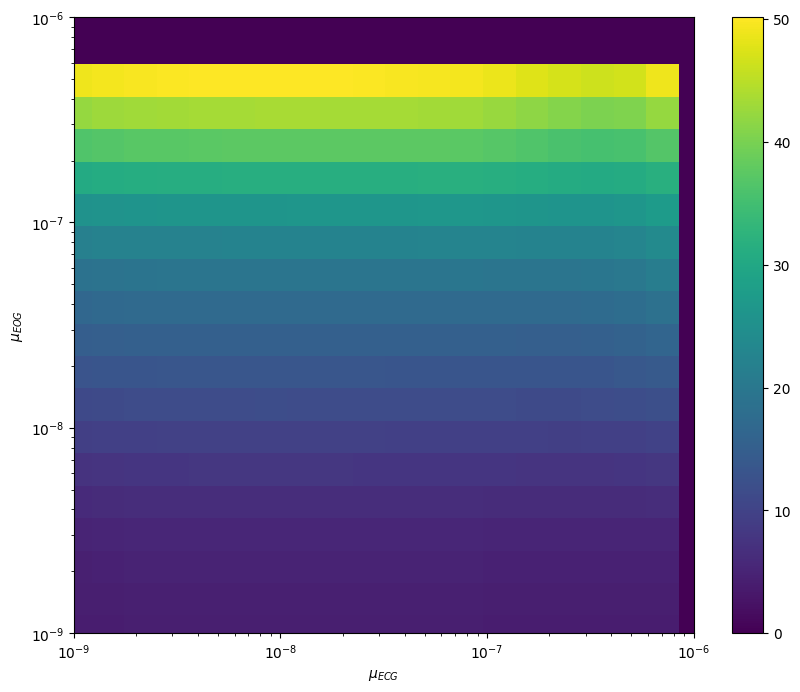

In [ ]:
mus_ECG = np.logspace(-9, -6, num=20)
mus_EOG = np.logspace(-9, -6, num=20)

r_EEG_ECG = get_corr(EEG[12000:], ECG[12000:], auto = False)
r_EEG_EOG = get_corr(EEG[12000:], EOG[12000:], auto = False)
E_r_EEG_ECG = np.sum(r_EEG_ECG**2)
E_r_EEG_EOG = np.sum(r_EEG_EOG**2)

mu_ECG_matrix, mu_EOG_matrix = np.meshgrid(mus_ECG, mus_EOG)
fmECG_EOG_matrix = np.zeros_like(mu_ECG_matrix)

for i, mu_ECG in enumerate(mus_ECG):
    for j, mu_EOG in enumerate(mus_EOG):
        e, y_hat_ECG, y_hat_EOG, w_ECG, w_EOG = LMS(EEG, ECG, EOG, mu_ECG=mu_ECG, mu_EOG=mu_EOG)
        r_e_ECG = get_corr(e[12000:], ECG[12000:], auto = False)
        r_e_EOG = get_corr(e[12000:], EOG[12000:], auto = False)
        E_r_e_ECG = np.sum(r_e_ECG**2)
        E_r_e_EOG = np.sum(r_e_EOG**2)

        fmECG = E_r_EEG_ECG/E_r_e_ECG  # Factor de mejora ECG
        fmEOG = E_r_EEG_EOG/E_r_e_EOG  # Factor de mejora ECG

        fmECG_EOG_matrix[j, i] = fmECG + fmEOG

X, Y = np.meshgrid(mus_ECG, mus_EOG)
fig = plt.figure(figsize=(10, 8))
plt.pcolormesh(X, Y, fmECG_EOG_matrix, shading='auto', cmap='viridis')
plt.xlabel(r'$\mu_{ECG}$')
plt.ylabel(r'$\mu_{EOG}$')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-9,1e-6)
plt.ylim(1e-9,1e-6)
plt.colorbar()
plt.show()

244180.23189808734

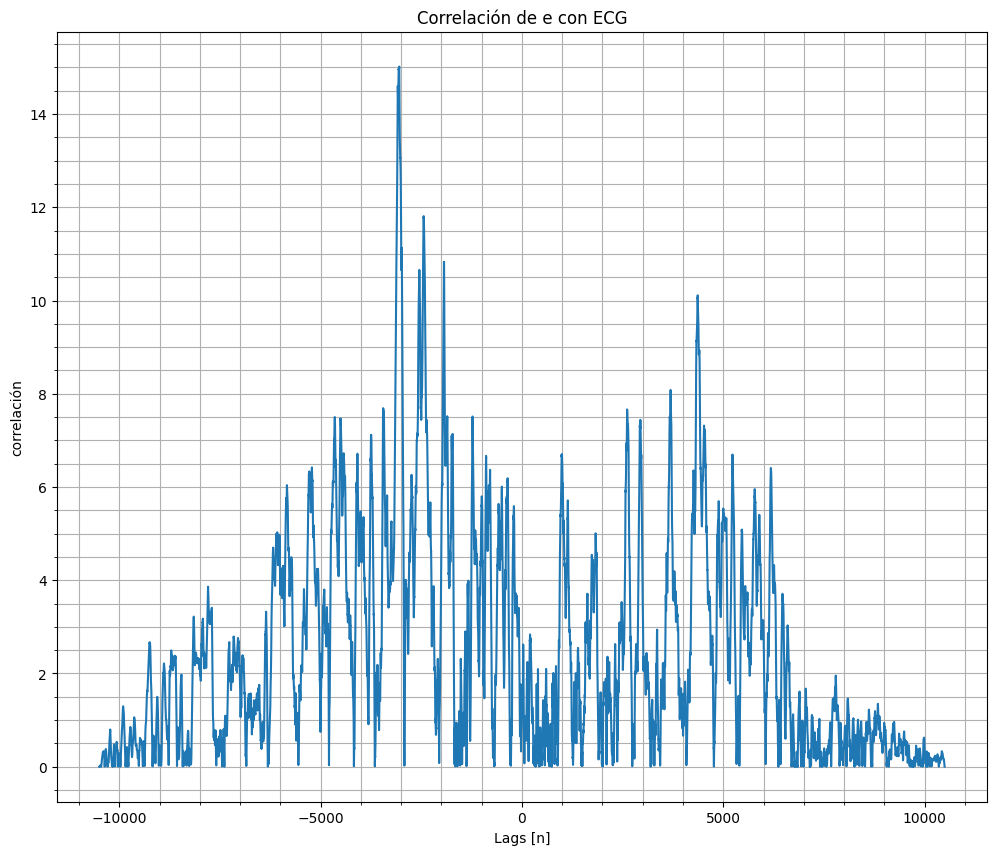

In [ ]:
r = get_corr(e[12000:], EOG[12000:], auto = False)

x = np.arange(-len(r)//2,len(r)//2)

plt.figure(figsize=(12, 10))

plt.plot(x,np.abs(r))
plt.minorticks_on()
plt.grid(True, which='both')
plt.title('Correlación de e con ECG')
plt.xlabel('Lags [n]')
plt.ylabel('correlación')

np.sum(r**2)

In [ ]:
def plot_corr_diff(EEG, ECG, EOG, e):

  r_pre_ECG = get_corr(EEG, ECG, auto = False)
  r_pre_EOG = get_corr(EEG, EOG, auto = False)
  r_pos_ECG = get_corr(e, ECG, auto = False)
  r_pos_EOG = get_corr(e, EOG, auto = False)

  maxLag = len(r_pre_ECG)//2

  x = np.arange(-maxLag, maxLag+1)

  fig, ax = plt.subplots(2,2, figsize=(12, 10))

  ax[0,0].plot(x, np.abs(r_pre_ECG), label=f"E={np.sum(r_pre_ECG**2):.2e}")
  ax[0,0].minorticks_on()
  ax[0,0].grid(True, which='both')
  ax[0,0].set_title('Correlación original de EEG con ECG')
  ax[0,0].set_xlabel('Lags [n]')
  ax[0,0].set_ylabel('correlación')
  ax[0,0].legend()

  ax[1,0].plot(x, np.abs(r_pre_EOG), label=f"E={np.sum(r_pre_EOG**2):.2e}")
  ax[1,0].minorticks_on()
  ax[1,0].grid(True, which='both')
  ax[1,0].set_title('Correlación original de EEG con EOG')
  ax[1,0].set_xlabel('Lags [n]')
  ax[1,0].set_ylabel('correlación')
  ax[1,0].legend()

  ax[0,1].plot(x, np.abs(r_pos_ECG), label=f"E={np.sum(r_pos_ECG**2):.2e}")
  ax[0,1].minorticks_on()
  ax[0,1].grid(True, which='both')
  ax[0,1].set_title('Correlación final de EEG con ECG')
  ax[0,1].set_xlabel('Lags [n]')
  ax[0,1].set_ylabel('correlación')
  ax[0,1].legend()

  ax[1,1].plot(x, np.abs(r_pos_EOG), label=f"E={np.sum(r_pos_EOG**2):.2e}")
  ax[1,1].minorticks_on()
  ax[1,1].grid(True, which='both')
  ax[1,1].set_title('Correlación final de EEG con EOG')
  ax[1,1].set_xlabel('Lags [n]')
  ax[1,1].set_ylabel('correlación')
  ax[1,1].legend()

  plt.plot()

Factor ECG: 2.9686069631082614
Factor EOG: 13.545219671608232


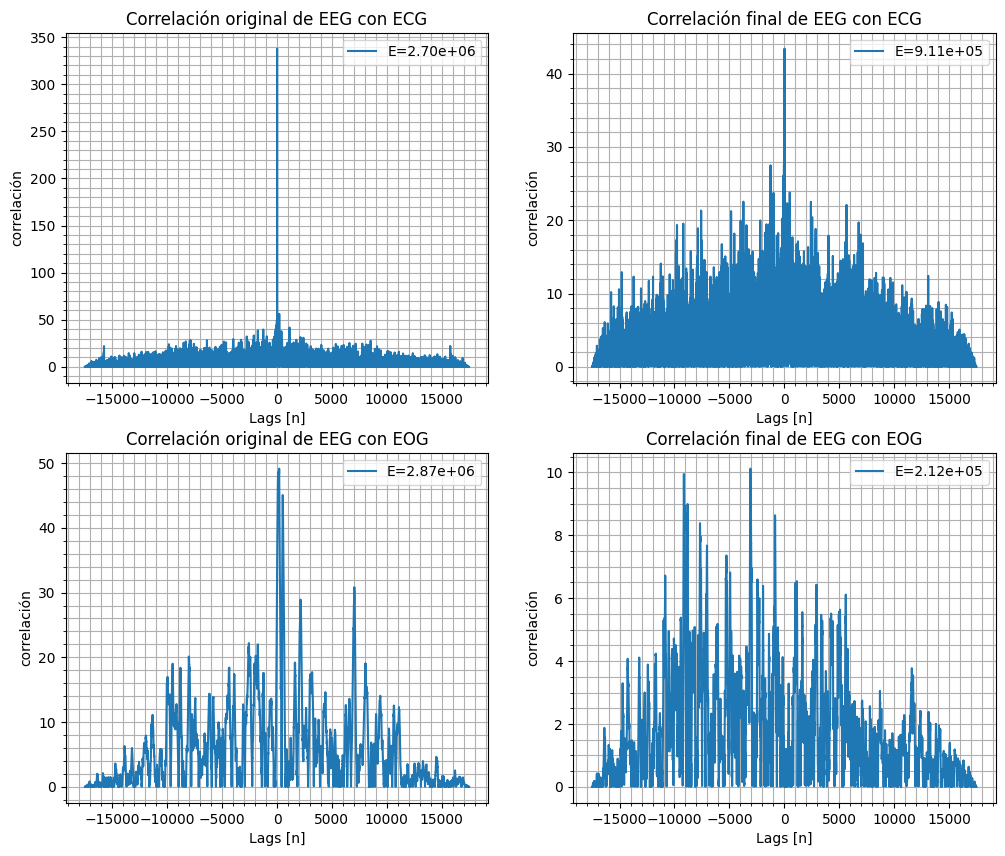

In [ ]:
init = 20*fs

plot_corr_diff(EEG[init:], ECG[init:], EOG[init:], e[init:])

factor_ECG, factor_EOG = get_factor(EEG[init:], ECG[init:], EOG[init:], e[init:])

print("Factor ECG:", factor_ECG)
print("Factor EOG:", factor_EOG)


# NLMS

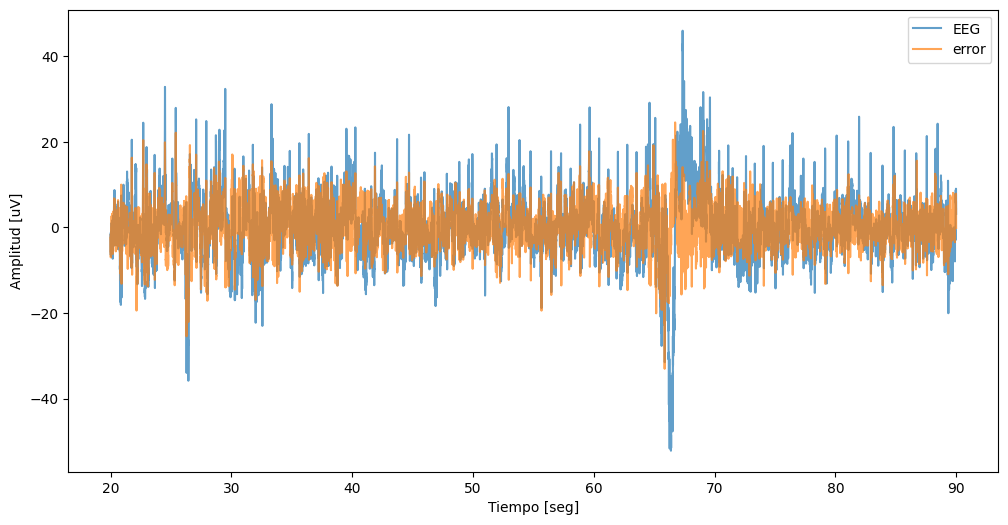

In [ ]:
def NLMS (EEG, ECG, EOG, M_ECG = 15, M_EOG = 750, mu_moño_ECG = 2e-4, delta_ECG = 1e-10, mu_moño_EOG = 5e-2, delta_EOG = 1e-10):
    N = len(EEG)

    w_ECG = np.zeros(M_ECG)
    w_EOG = np.zeros(M_EOG)
    y_hat_ECG = np.zeros(N)
    y_hat_EOG = np.zeros(N)
    e_ECG = np.zeros(N)
    e_EOG = np.zeros(N)

    maxM = max(M_ECG, M_EOG)

    # Inicialización de primeros maxM valores en 0
    w_ECG_history = [[0]*M_ECG]*(maxM-1)
    w_EOG_history = [[0]*M_EOG]*(maxM-1)

    for n in range(M_EOG-1, N):
        ECG_n = ECG[n-M_ECG+1:n+1]
        EOG_n = EOG[n-M_EOG+1:n+1]

        E_ECG = np.sum(ECG[n-(M_ECG-1): n+1]**2)  #Energía
        E_EOG = np.sum(EOG[n-(M_EOG-1): n+1]**2)  #Energía

        y_hat_ECG[n] = np.dot(w_ECG, ECG_n)
        e_ECG[n] = EEG[n] - y_hat_ECG[n]

        y_hat_EOG[n] = np.dot(w_EOG, EOG_n)
        e_EOG[n] = e_ECG[n] - y_hat_EOG[n]

        w_ECG += mu_moño_ECG * e_ECG[n] * ECG_n /(delta_ECG + E_ECG)
        w_EOG += mu_moño_EOG * e_EOG[n] * EOG_n/(delta_EOG + E_EOG)

        w_ECG_history.append(w_ECG.copy())
        w_EOG_history.append(w_EOG.copy())

    return e_EOG, y_hat_ECG, y_hat_EOG, w_ECG_history, w_EOG_history

e, y_hat_ECG, y_hat_EOG, w_ECG, w_EOG = NLMS(EEG, ECG, EOG)

t=np.arange(len(EEG))/fs
plt.figure(figsize=(12, 6))
plt.plot(t[20*fs:], EEG[20*fs:], alpha = 0.7, label = 'EEG')
plt.plot(t[20*fs:], e[20*fs:], alpha = 0.7, label = 'error')
plt.xlabel('Tiempo [seg]')
plt.ylabel('Amplitud [uV]')
plt.legend()
plt.show()

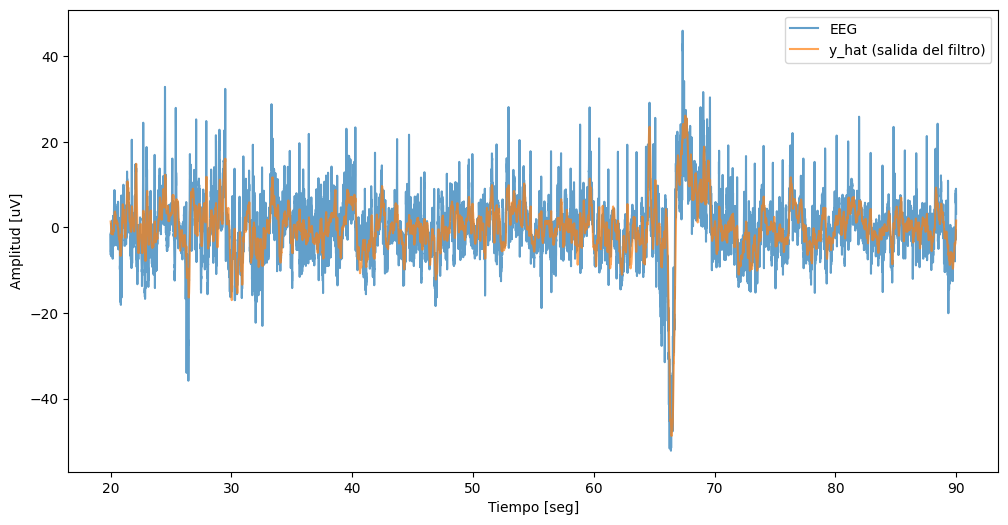

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(t[20*fs:], EEG[20*fs:], alpha = 0.7, label = 'EEG')
plt.plot(t[20*fs:], y_hat_EOG[20*fs:], alpha = 0.7, label = 'y_hat (salida del filtro)')
plt.xlabel('Tiempo [seg]')
plt.ylabel('Amplitud [uV]')
plt.legend()
plt.show()

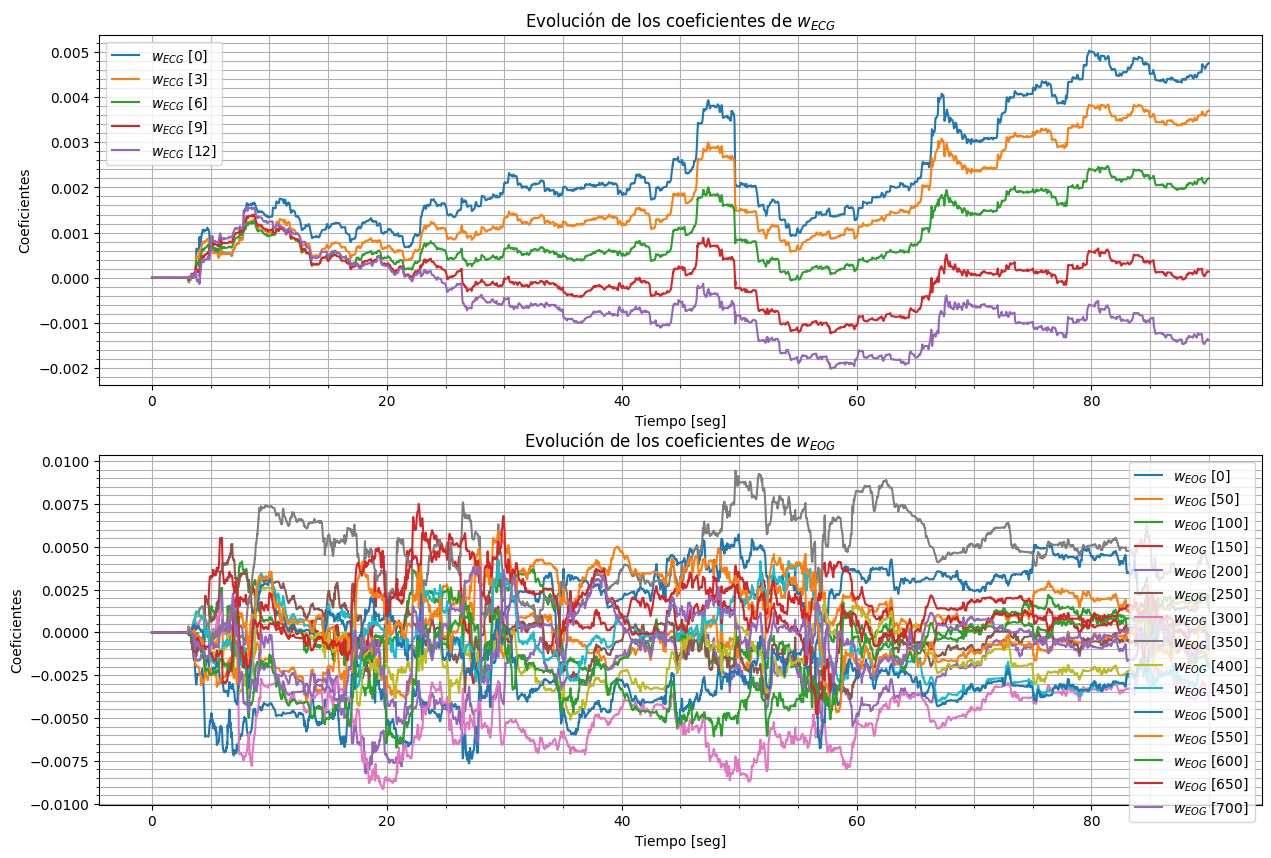

In [ ]:
plot_coef_hist(EEG, w_ECG, w_EOG)

Factor ECG: 2.038966999014784
Factor EOG: 14.097532024843117


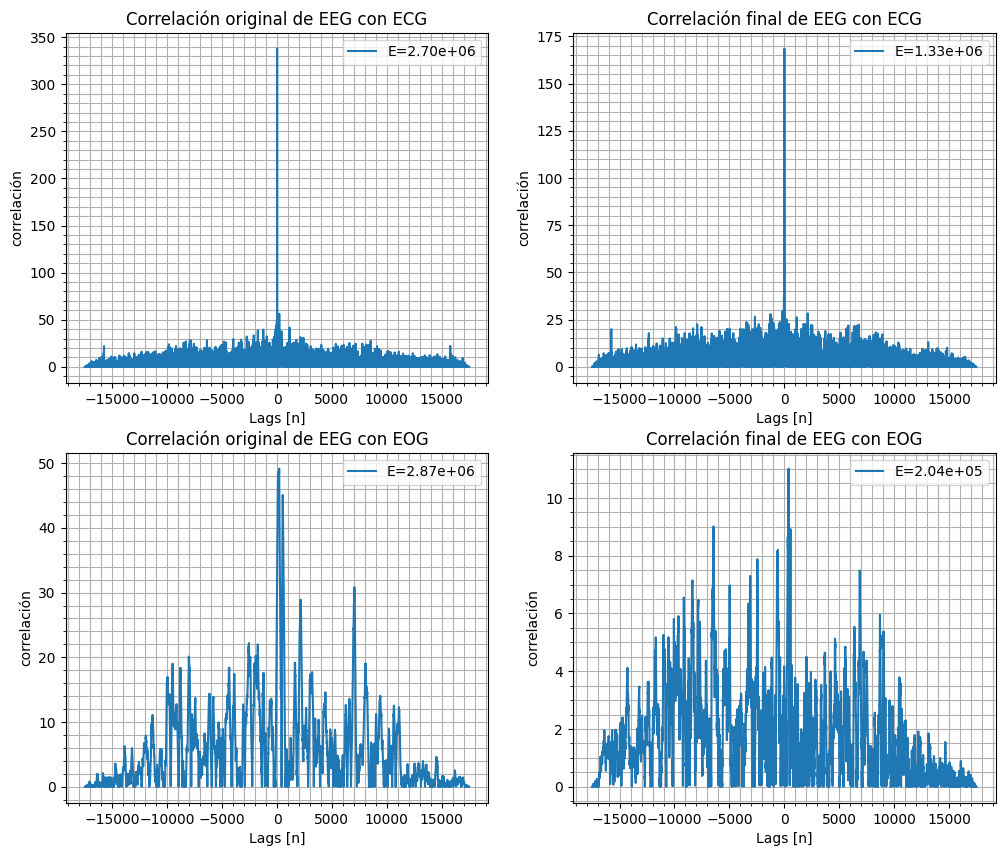

In [ ]:
init = 20*fs

plot_corr_diff(EEG[init:], ECG[init:], EOG[init:], e[init:])

factor_ECG, factor_EOG = get_factor(EEG[init:], ECG[init:], EOG[init:], e[init:])

print("Factor ECG:", factor_ECG)
print("Factor EOG:", factor_EOG)

# Q-LMS

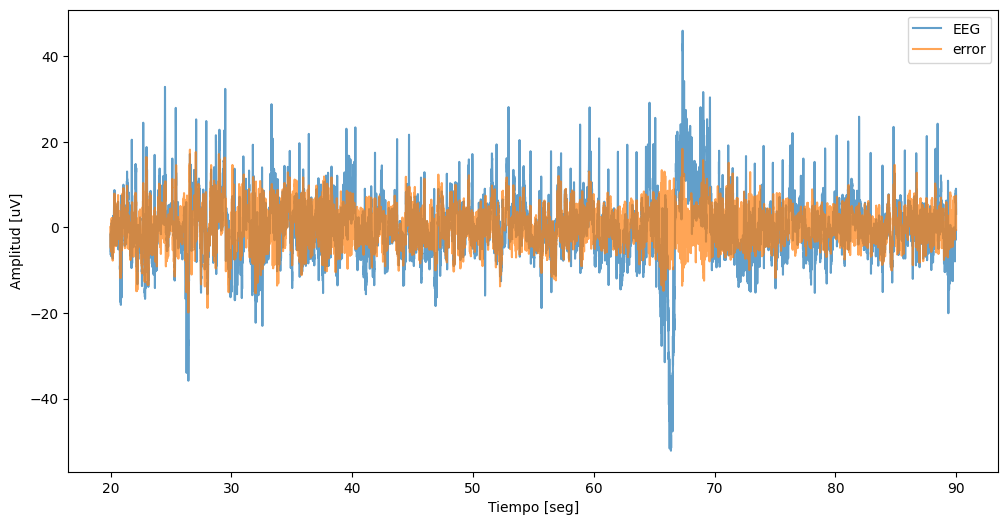

In [ ]:
def QLMS (EEG, ECG, EOG, M_ECG = 15, M_EOG = 750, mu_ECG = 1e-8, mu_EOG = 1e-7, beta = 0.5, gamma = 5e-3):
    N = len(EEG)

    w_ECG = np.zeros(M_ECG)
    w_EOG = np.zeros(M_EOG)
    y_hat_ECG = np.zeros(N)
    y_hat_EOG = np.zeros(N)
    e_ECG = np.zeros(N)
    e_EOG = np.zeros(N)

    maxM = max(M_ECG, M_EOG)

    # Inicialización de primeros maxM valores en 0
    w_ECG_history = [[0]*M_ECG]*(maxM-1)
    w_EOG_history = [[0]*M_EOG]*(maxM-1)

    qupper_ECG = 2/(mu_ECG * ev_max_ECG)
    qupper_EOG = 2/(mu_EOG * ev_max_EOG)

    psi_ECG = 0
    psi_EOG = 0

    q_lambda = lambda psi, qupper: qupper if psi > qupper else (1 if psi < 1 else psi)

    for n in range(M_EOG-1, N):
        ECG_n = ECG[n-M_ECG+1 : n+1]
        EOG_n = EOG[n-M_EOG+1 : n+1]

        y_hat_ECG[n] = np.dot(w_ECG, ECG_n)
        e_ECG[n] = EEG[n] - y_hat_ECG[n]

        y_hat_EOG[n] = np.dot(w_EOG, EOG_n)
        e_EOG[n] = e_ECG[n] - y_hat_EOG[n]

        psi_ECG = beta * psi_ECG + gamma * e_ECG[n]**2
        psi_EOG = beta * psi_EOG + gamma * e_EOG[n]**2

        q_ECG = q_lambda(psi_ECG, qupper_ECG)
        q_EOG = q_lambda(psi_EOG, qupper_EOG)

        w_ECG += mu_ECG * (q_ECG+1) * e_ECG[n] * ECG_n
        w_EOG += mu_EOG * (q_EOG+1) *e_EOG[n] * EOG_n

        w_ECG_history.append(w_ECG.copy())
        w_EOG_history.append(w_EOG.copy())

    return e_EOG, y_hat_ECG, y_hat_EOG, w_ECG_history, w_EOG_history

e, y_hat_ECG, y_hat_EOG, w_ECG, w_EOG = QLMS(EEG, ECG, EOG)

t=np.arange(len(EEG))/fs
plt.figure(figsize=(12, 6))
plt.plot(t[20*fs:], EEG[20*fs:], alpha = 0.7, label = 'EEG')
plt.plot(t[20*fs:], e[20*fs:], alpha = 0.7, label = 'error')
plt.xlabel('Tiempo [seg]')
plt.ylabel('Amplitud [uV]')
plt.legend()
plt.show()

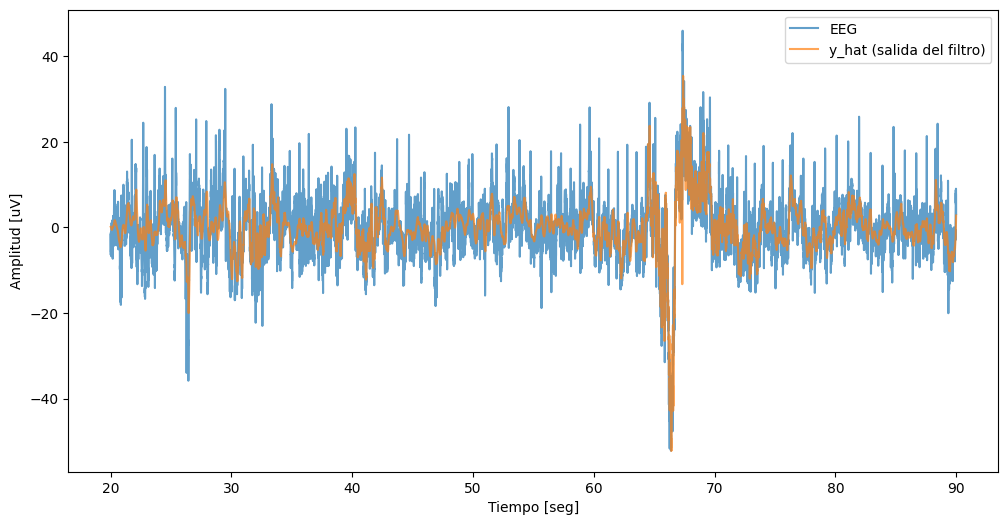

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(t[20*fs:], EEG[20*fs:], alpha = 0.7, label = 'EEG')
plt.plot(t[20*fs:], y_hat_EOG[20*fs:], alpha = 0.7, label = 'y_hat (salida del filtro)')
plt.xlabel('Tiempo [seg]')
plt.ylabel('Amplitud [uV]')
plt.legend()
plt.show()

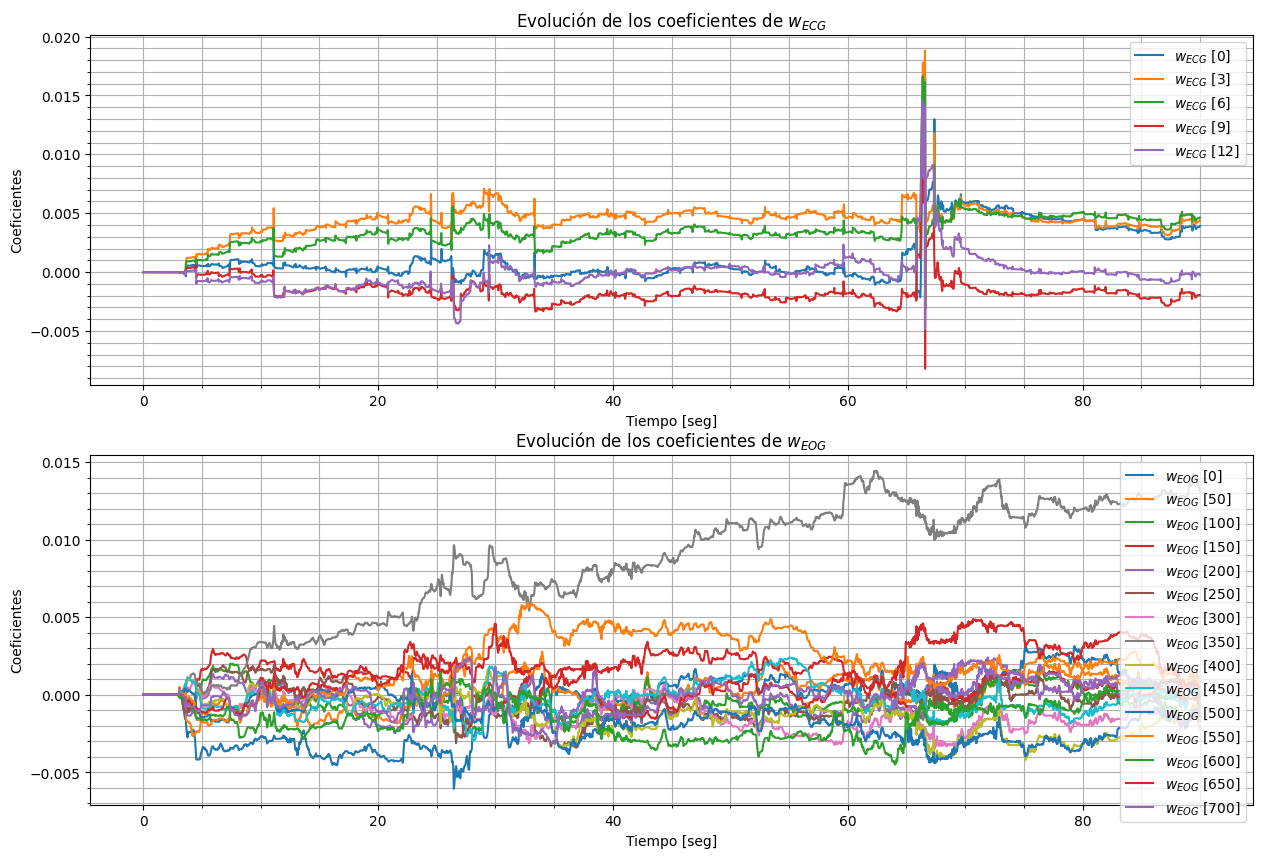

In [ ]:
plot_coef_hist(EEG, w_ECG, w_EOG)

Factor ECG: 3.5064429793958016
Factor EOG: 18.260174349440394


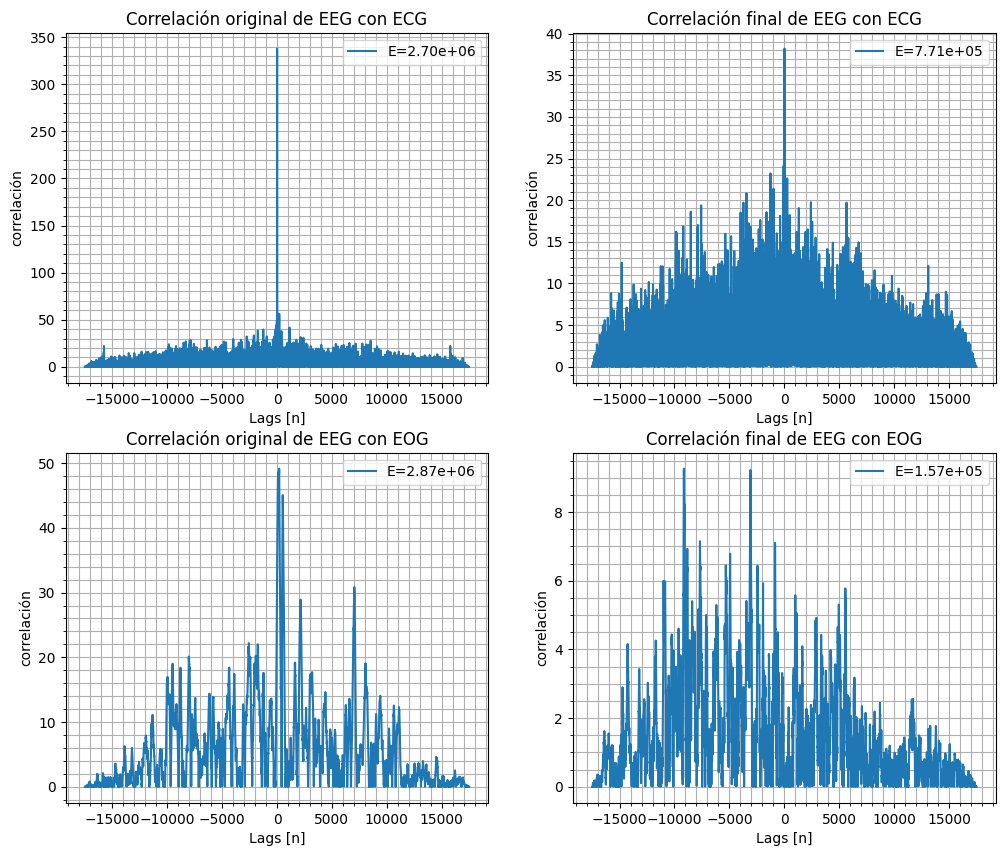

In [ ]:
init = 20*fs

plot_corr_diff(EEG[init:], ECG[init:], EOG[init:], e[init:])

factor_ECG, factor_EOG = get_factor(EEG[init:], ECG[init:], EOG[init:], e[init:])

print("Factor ECG:", factor_ECG)
print("Factor EOG:", factor_EOG)

#RLS

En un entorno con una alta SNR, el algoritmo RLS suele converger más rápido y proporcionar estimaciones de filtro más precisas. En contraste, en un entorno con una baja SNR, la presencia significativa de ruido puede dificultar la convergencia del algoritmo RLS y generar estimaciones menos confiables de los coeficientes del filtro.

$SNR = 10 \cdot log(signal / noise) \approx 10 \cdot log (20/40) = -3dB \qquad$  ----> SNR baja ----> Convergencia lenta

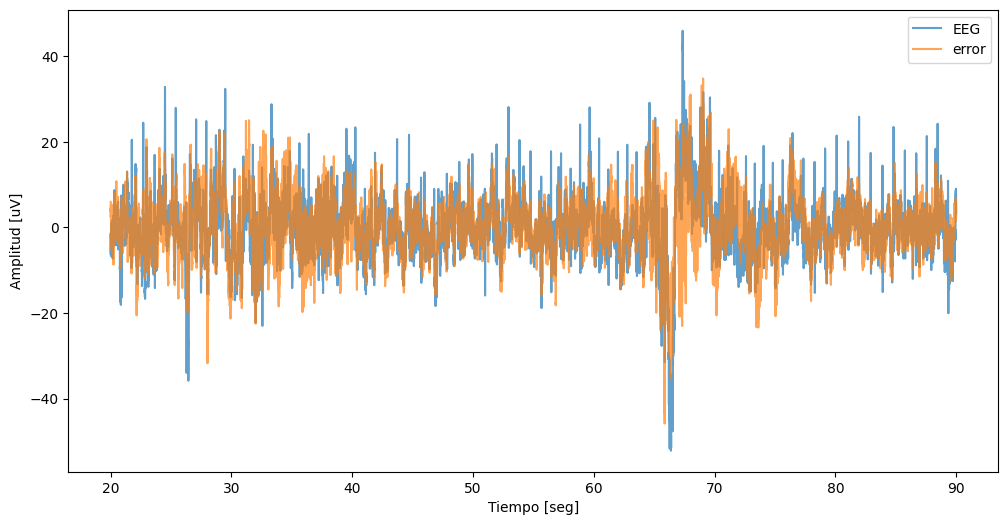

In [ ]:
M_ECG = 15
M_EOG = 750

N = len(EEG)

tau_ECG = 1000
λ_ECG = np.exp(-1/tau_ECG)
alpha_ECG = 1
delta_ECG = np.var(ECG)*(1-λ_ECG)**alpha_ECG

tau_EOG = 1000
λ_EOG = np.exp(-1/tau_EOG)
alpha_EOG = 1
delta_EOG = 0.01*np.var(EOG) #np.var(EOG)*(1-λ_EOG)**alpha_EOG

w_ECG = np.zeros(M_ECG)
w_EOG = np.zeros(M_EOG)
y_hat_ECG = np.zeros(N)
y_hat_EOG = np.zeros(N)
e_ECG = np.zeros(N)
e_EOG = np.zeros(N)

maxM = max(M_ECG, M_EOG)

# Inicialización de primeros maxM valores en 0
w_ECG_history = [[0]*M_ECG]*(maxM-1)
w_EOG_history = [[0]*M_EOG]*(maxM-1)

I_ECG = np.identity(M_ECG)
P_ECG = (1.0 / delta_ECG) * I_ECG
I_EOG = np.identity(M_EOG)
P_EOG = (1.0 / delta_EOG) * I_EOG

for n in range(maxM-1, N):
    ECG_n = ECG[n-M_ECG+1 : n+1]
    EOG_n = EOG[n-M_EOG+1 : n+1]

    g_bar_ECG = np.matmul(P_ECG,ECG_n)/λ_ECG
    alfa_bar_ECG = 1 + np.dot(g_bar_ECG.T,ECG_n)
    g_ECG = g_bar_ECG / alfa_bar_ECG
    P_ECG = P_ECG/λ_ECG - np.outer(g_ECG, g_bar_ECG)
    P_ECG = (P_ECG + np.conj(P_ECG.T)) / 2  # Aseguro que sea hermítica

    y_hat_ECG[n] = np.dot(w_ECG, ECG_n)
    e_ECG[n] = EEG[n] - y_hat_ECG[n]
    w_ECG += g_ECG * e_ECG[n]

    g_bar_EOG = np.matmul(P_EOG,EOG_n)/λ_EOG
    alfa_bar_EOG = 1 + np.dot(g_bar_EOG.T,EOG_n)
    g_EOG = g_bar_EOG / alfa_bar_EOG
    P_EOG = P_EOG/λ_EOG - np.outer(g_EOG, g_bar_EOG)
    P_EOG = (P_EOG + np.conj(P_EOG.T)) / 2  # Aseguro que sea hermítica

    y_hat_EOG[n] = np.dot(w_EOG, EOG_n)
    e_EOG[n] = e_ECG[n] - y_hat_EOG[n]
    w_EOG += g_EOG * e_EOG[n]

    w_ECG_history.append(w_ECG.copy())
    w_EOG_history.append(w_EOG.copy())

t=np.arange(len(EEG))/fs
plt.figure(figsize=(12, 6))
plt.plot(t[20*fs:], EEG[20*fs:], alpha = 0.7, label = 'EEG')
plt.plot(t[20*fs:], e_EOG[20*fs:], alpha = 0.7, label = 'error')
plt.xlabel('Tiempo [seg]')
plt.ylabel('Amplitud [uV]')
plt.legend()
plt.show()

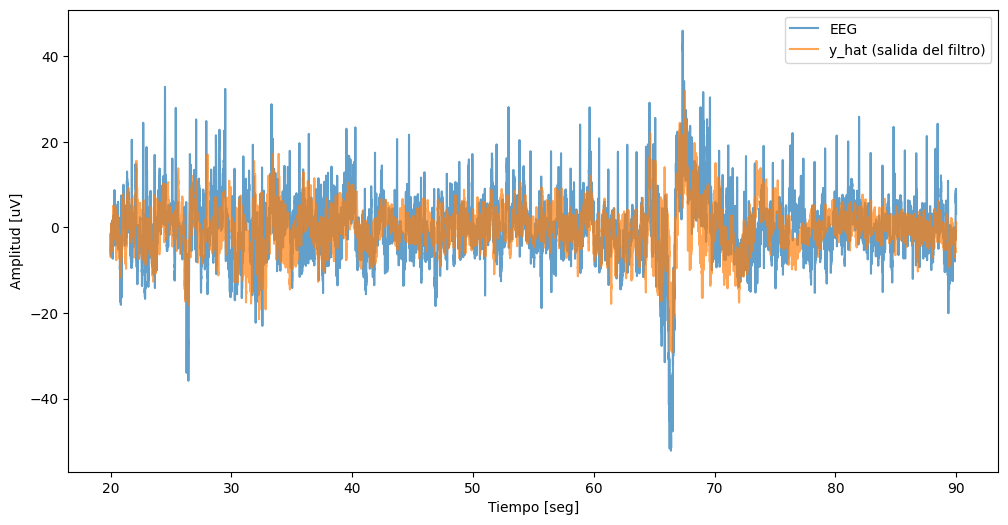

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(t[20*fs:], EEG[20*fs:], alpha = 0.7, label = 'EEG')
plt.plot(t[20*fs:], y_hat_EOG[20*fs:], alpha = 0.7, label = 'y_hat (salida del filtro)')
plt.xlabel('Tiempo [seg]')
plt.ylabel('Amplitud [uV]')
plt.legend()
plt.show()

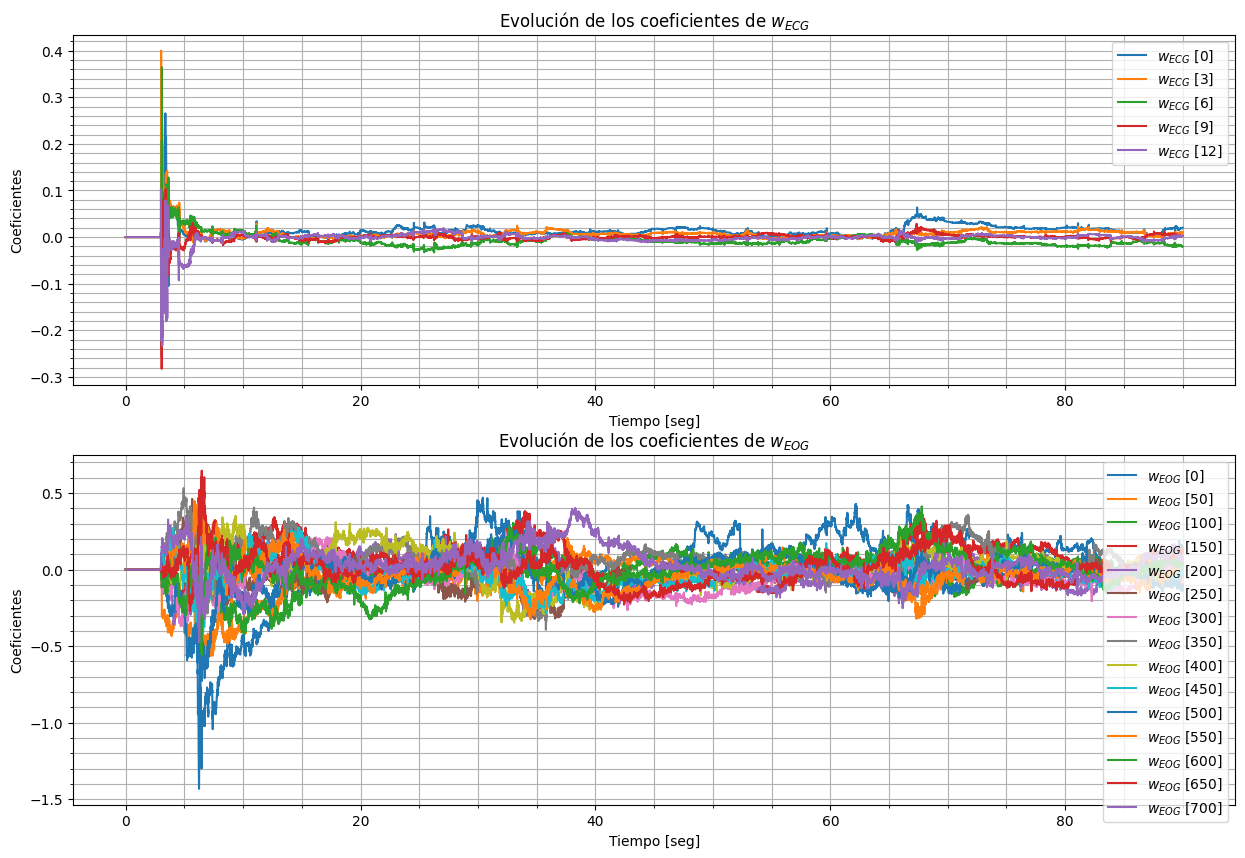

In [ ]:
plot_coef_hist(EEG, w_ECG_history, w_EOG_history)

Factor ECG: 2.4461536606933176
Factor EOG: 7.499914273704105


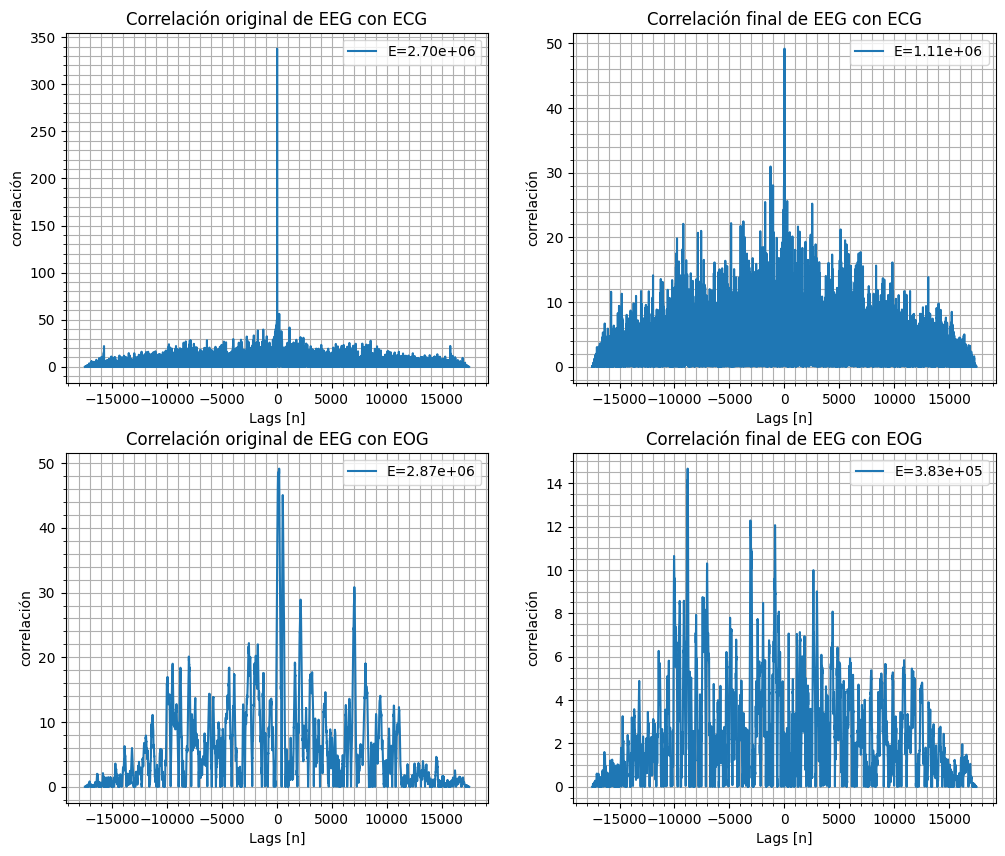

In [ ]:
init = 20*fs

plot_corr_diff(EEG[init:], ECG[init:], EOG[init:], e[init:])

factor_ECG, factor_EOG = get_factor(EEG[init:], ECG[init:], EOG[init:], e[init:])

print("Factor ECG:", factor_ECG)
print("Factor EOG:", factor_EOG)